### 1. Libraries Installation

In [73]:
!pip install numpy

In [74]:
!pip install matplotlib

In [92]:
!pip install tensorflow

In [119]:
!pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (8.9 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached scipy-1.16.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]


In [14]:
!pip install seaborn

  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]━━━ 2/4 [pandas]


### 2. Dataset Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt


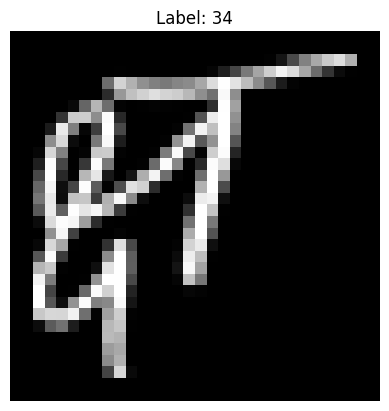

In [2]:
data = np.load('../data/dataset.npz', allow_pickle=True)

X_train = data['arr_0']  # pixel data
Y_train = data['arr_1']  # labels
X_test = data['arr_2']   # pixel data
Y_test = data['arr_3']   # labels

# Example image
index = 1700
plt.imshow(X_train[index], cmap='gray')
plt.title(f'Label: {Y_train[index]}')
plt.axis('off')
plt.show()


In [4]:
X_train[2001], Y_train[2001]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(32, 32), dtype=uint8),
 np.int64(34))

In [5]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(78200, 78200, 13800, 13800)

In [6]:
len(X_train) + len(X_test)

92000

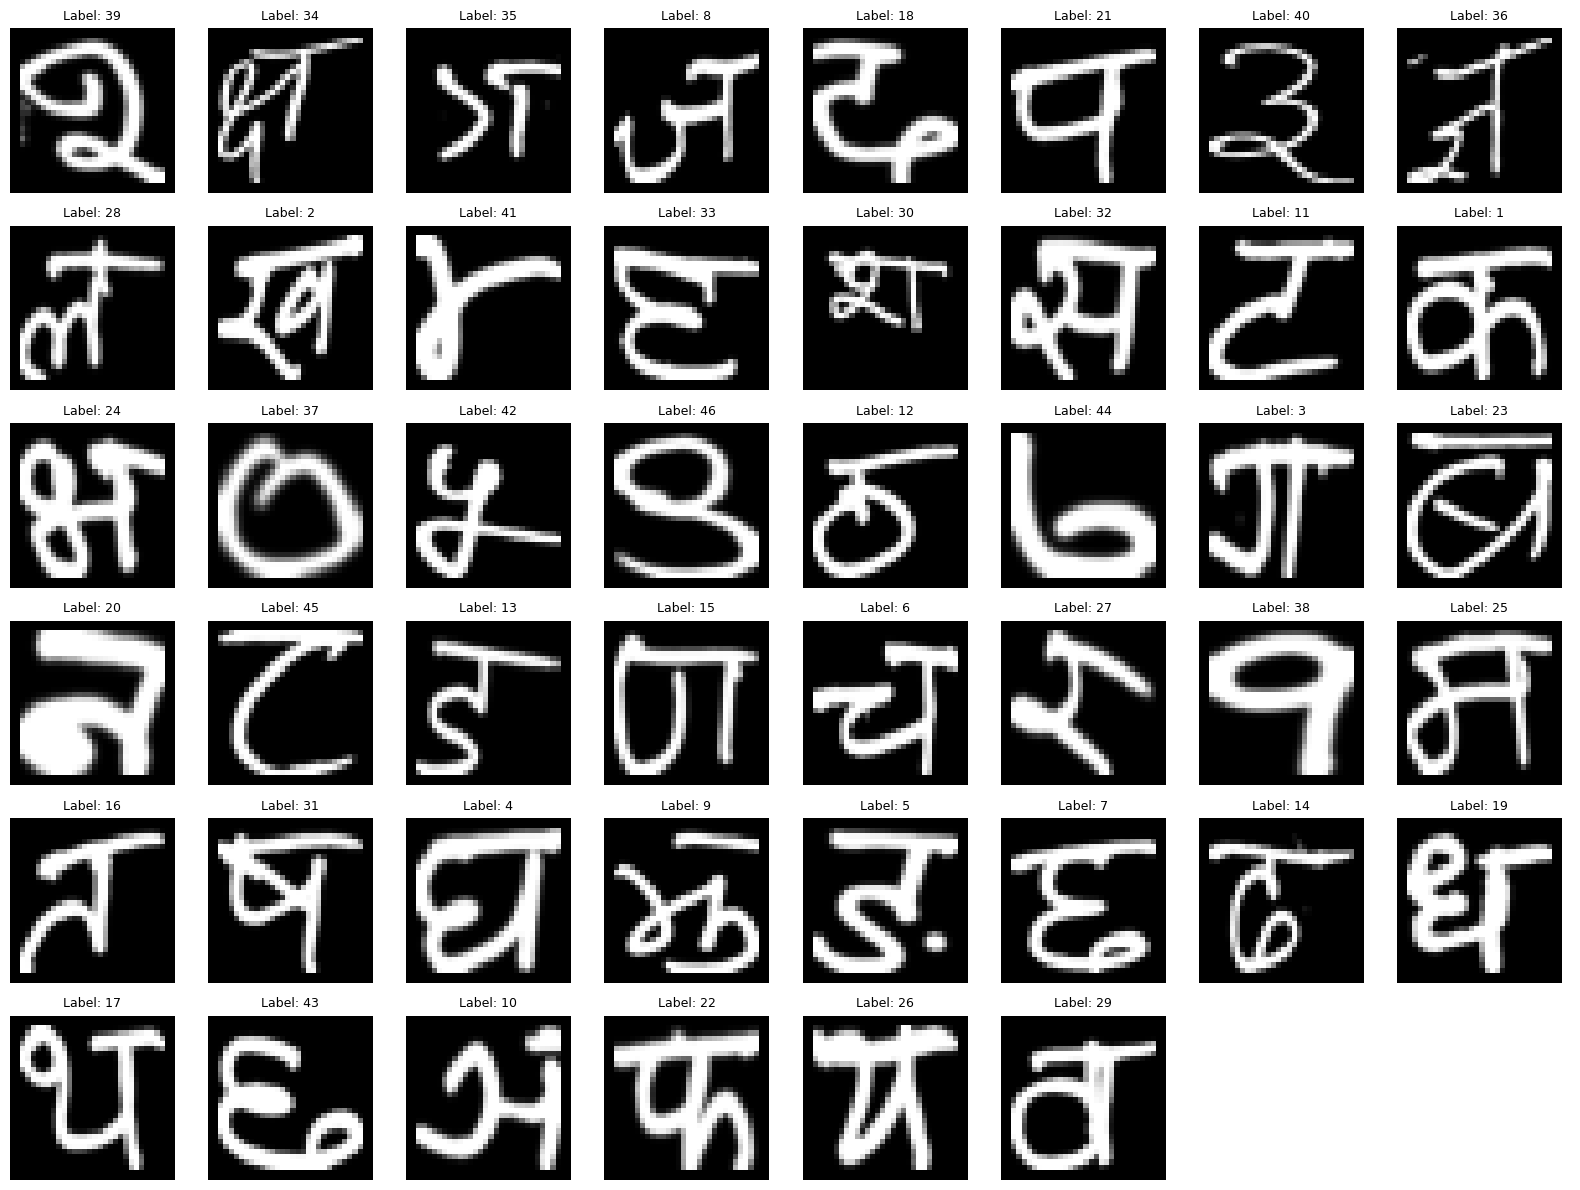

In [7]:
num_classes = 46
images_per_class = 1700

cols = 8
rows = 6  # 6×8 = 48 slots (2 unused)

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

image_index = 0

for i in range(num_classes):
    axes[i].imshow(X_train[image_index], cmap='gray')
    axes[i].set_title(f'Label: {Y_train[image_index]}', fontsize=9)
    axes[i].axis('off')

    image_index += images_per_class

# Hide unused subplots
for j in range(num_classes, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 3. Implementing Algorithms

#### 3.0. Validation Split

In [8]:
num_classes = 46
train_per_class = 1600
val_per_class = 100

X_train_new, Y_train_new = [], []
X_val, Y_val = [], []

for i in range(num_classes):
    start = i * 1700
    end = start + 1700
    
    # Training: first 1600 images of this class
    for j in range(train_per_class):
        X_train_new.append(X_train[start + j])
        Y_train_new.append(Y_train[start + j])
    
    # Validation: last 100 images of this class
    for j in range(train_per_class, train_per_class + val_per_class):
        X_val.append(X_train[start + j])
        Y_val.append(Y_train[start + j])

# Convert to NumPy arrays (each element still keeps its original shape)
X_train_new = np.array(X_train_new)
Y_train_new = np.array(Y_train_new)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [9]:
print("Training:", X_train_new.shape, Y_train_new.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Testing:", X_test.shape, Y_test.shape)
print(X_train_new.shape[0] + X_val.shape[0] + X_test.shape[0])

Training: (73600, 32, 32) (73600,)
Validation: (4600, 32, 32) (4600,)
Testing: (13800, 32, 32) (13800,)
92000


#### 3.1. Implementing Neural Network

##### 3.1.1. Preparing Data According to Network Class

In [10]:
#preperaing data

# -------------------------------
# Label one-hot encoding for training
# -------------------------------
def vectorized_label(y, num_classes=46):
    v = np.zeros((num_classes, 1))
    v[y - 1] = 1.0   # shift labels from 1–46 to 0–45
    return v

# -------------------------------
# Normalize 0-255 → 0-1
# -------------------------------
X_train_new_norm = X_train_new.astype(np.float32) / 255.0
X_val_norm = X_val.astype(np.float32) / 255.0
X_test_norm = X_test.astype(np.float32) / 255.0

# # Rescale to -1 to 1
# X_train_new_norm = X_train_new_norm * 2 - 1
# X_val_norm = X_val_norm * 2 - 1
# X_test_norm = X_test_norm * 2 - 1

# -------------------------------
# Flatten images (32×32 → 1024)
# -------------------------------
X_train_new_norm = X_train_new_norm.reshape(len(X_train_new_norm), 1024)
X_val_norm = X_val_norm.reshape(len(X_val_norm), 1024)
X_test_norm = X_test_norm.reshape(len(X_test_norm), 1024)

# -------------------------------
# Convert to column vectors
# -------------------------------
X_train_new_norm = X_train_new_norm.reshape(len(X_train_new_norm), 1024, 1)
X_val_norm = X_val_norm.reshape(len(X_val_norm), 1024, 1)
X_test_norm = X_test_norm.reshape(len(X_test_norm), 1024, 1)

# -------------------------------
# One-hot encode labels for training
# -------------------------------
Y_train_vec = [vectorized_label(y) for y in Y_train_new]

# -------------------------------
# Validation labels (use integers 0–45 for evaluate)
# -------------------------------
Y_val_vec = Y_val - 1   # shift 1–46 → 0–45
Y_test_vec = Y_test - 1

# -------------------------------
# Zip into network-ready format
# -------------------------------
training_data = list(zip(X_train_new_norm, Y_train_vec))
validation_data = list(zip(X_val_norm, Y_val_vec))
test_data = list(zip(X_test_norm, Y_test_vec))

##### 3.1.2. Neural Network With Sigmoid and Random Weight Initialization

In [11]:
import network

# # -------------------------------
# # Initialize network
# # -------------------------------
# #const net.SGD(training_data, 5, 10, 3.0, test_data=validation_data)
# #net = network.Network([1024, 30, 46]), 25.57%
# #net = network.Network([1024, 30, 5, 46]), 5.11%
# #net = network.Network([1024, 50, 46]), 7.89%
# #net = network.Network([1024, 30, 46]), 20.48%
# #net = network.Network([1024, 15, 46]), 22.26%
# #net = network.Network([1024, 15, 46]), 28.65%

# #const net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)
# #net = network.Network([1024, 30, 46]), 61.78%
# #net = network.Network([1024, 30, 46]), 64.17%
# #net = network.Network([1024, 30, 46]), 54.39%
# #net = network.Network([1024, 30, 46]), 66.50%
# #net = network.Network([1024, 30, 46]), 64.57%
# #net = network.Network([1024, 30, 46], pre_model_path), 66.09%
# model_dir = os.path.join(os.getcwd(), "..", "model")
# pre_model_path = os.path.join(model_dir, "digit_model_re_63")

# #net = network.Network([1024, 30, 46])

# net = network.Network([1024, 30, 46])
# net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)


# #const net = network.Network([1024, 30, 46], pre_model_path(digit_model_64.npz))
# #net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data), 65
# #net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data) #Image Rescale to -1 to 1, 63

# #net = network.Network([1024, 30, 46])
# #Image Rescale to -1 to 1 
# #net.SGD(training_data, epochs=50, mini_batch_size=50, eta=2.0, test_data=validation_data), #Image Rescale to -1 to 1  

# # net = network.Network([1024, 60, 30, 46])
# # net.SGD(training_data, epochs=500, mini_batch_size=50, eta=1.0, test_data=validation_data)
# # Epoch 211: 318 / 4600
# # Epoch 212: 341 / 4600

net = network.Network([1024, 30, 46])
net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)

# os.makedirs(model_dir, exist_ok=True)

# save_path = os.path.join(model_dir, "digit_model_sigmoid.npz")

# np.savez_compressed(save_path, 
#                     weights=np.array(net.weights, dtype=object),
#                     biases=np.array(net.biases, dtype=object))
# print(f"Model saved to: {save_path}")

Epoch 0: 978 / 4600
Epoch 1: 1524 / 4600
Epoch 2: 1828 / 4600
Epoch 3: 1944 / 4600
Epoch 4: 2103 / 4600
Epoch 5: 2263 / 4600
Epoch 6: 2346 / 4600
Epoch 7: 2400 / 4600
Epoch 8: 2436 / 4600
Epoch 9: 2564 / 4600
Epoch 10: 2661 / 4600
Epoch 11: 2623 / 4600
Epoch 12: 2663 / 4600
Epoch 13: 2675 / 4600
Epoch 14: 2680 / 4600
Epoch 15: 2723 / 4600
Epoch 16: 2811 / 4600
Epoch 17: 2683 / 4600
Epoch 18: 2774 / 4600
Epoch 19: 2791 / 4600
Epoch 20: 2799 / 4600
Epoch 21: 2843 / 4600
Epoch 22: 2818 / 4600
Epoch 23: 2785 / 4600
Epoch 24: 2851 / 4600
Epoch 25: 2880 / 4600
Epoch 26: 2847 / 4600
Epoch 27: 2842 / 4600
Epoch 28: 2807 / 4600
Epoch 29: 2897 / 4600
Epoch 30: 2895 / 4600
Epoch 31: 2849 / 4600
Epoch 32: 2859 / 4600
Epoch 33: 2858 / 4600
Epoch 34: 2893 / 4600
Epoch 35: 2882 / 4600
Epoch 36: 2884 / 4600
Epoch 37: 2955 / 4600
Epoch 38: 2871 / 4600
Epoch 39: 2874 / 4600
Epoch 40: 2872 / 4600
Epoch 41: 2884 / 4600
Epoch 42: 2852 / 4600
Epoch 43: 2898 / 4600
Epoch 44: 2896 / 4600
Epoch 45: 2858 / 4600

##### 3.1.3. Neural Network With ReLu and He Weight Initialization

In [87]:
#import network_relu
# net_relu = network_relu.Network([1024, 30, 46])
# net_relu.SGD(training_data, epochs=500, mini_batch_size=50, eta=0.2, test_data=validation_data)
#62%

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)
# 100/4600

# net_relu = network_relu.Network([1024, 30, 10, 46])
# net_relu.SGD(training_data, epochs=50, mini_batch_size=50, eta=0.5, test_data=validation_data)
# 100/4600

# net_relu = network_relu.Network([1024, 30, 46])
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.5, test_data=validation_data)
# 1699 / 4600

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.5, test_data=validation_data)
# inconsistent Epoch 14: 1803 / 4600, Epoch 35: 1104 / 4600

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)
# 3720 / 4600

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)
# 3688 / 4600, digit_model_relu_60_30_0.1.npz

# net_relu = network_relu.Network([1024, 60, 30, 46])
# #---net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)
# #stuck of 100/4600

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)
#3681 / 4600, digit_model_relu_60_30_0.2.npz

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)
#3597 / 4600, digit_model_relu_60_30_0.3.npz

# net_relu = network_relu.Network([1024, 60, 30, 46])
# net_relu.initialize_weights_biases()
# net_relu.SGD(training_data, epochs=50, mini_batch_size=32, eta=0.2, test_data=validation_data)

# os.makedirs(model_dir, exist_ok=True)
# save_path = os.path.join(model_dir, "digit_model_relu_60_30.npz")

# np.savez_compressed(save_path, 
#                     weights=np.array(net_relu.weights, dtype=object),
#                     biases=np.array(net_relu.biases, dtype=object))

# print(f"Model saved to: {save_path}")

##### 3.1.4. Evaluation of Neural Network

In [15]:
import os
import network
import network_relu

# -------------------------------
# Evaluate on test data
# -------------------------------

model_dir = os.path.join(os.getcwd(), "..", "model")

# Sigmoid model
pre_model_path_sigmoid = os.path.join(model_dir, "digit_model_67.npz")
test_net_sigmoid = network.Network([1024, 30, 46], pre_model_path_sigmoid)

test_correct_s = test_net_sigmoid.evaluate(test_data)
test_total_s = len(test_data)
test_accuracy_s = test_correct_s / test_total_s * 100
print(f"Final Test Accuracy (Sigmoid): {test_correct_s} / {test_total_s} = {test_accuracy_s:.2f}%")

# ReLU model
pre_model_path_relu = os.path.join(model_dir, "digit_model_relu_60_30_0.2.npz")
test_net_relu = network_relu.Network([1024, 60, 30, 46], pre_model_path_relu)

test_correct = test_net_relu.evaluate(test_data)
test_total = len(test_data)
test_accuracy = test_correct / test_total * 100
print(f"Final Test Accuracy (ReLU): {test_correct} / {test_total} = {test_accuracy:.2f}%")

Model loaded from: /home/kebal/project/devnagari-classification/model/digit_model_67.npz
Final Test Accuracy (Sigmoid): 9481 / 13800 = 68.70%
Model loaded from: /home/kebal/project/devnagari-classification/model/digit_model_relu_60_30_0.2.npz
Final Test Accuracy (ReLU): 11092 / 13800 = 80.38%


Model loaded from: /home/kebal/project/devnagari-classification/model/digit_model_67.npz
Model loaded from: /home/kebal/project/devnagari-classification/model/digit_model_relu_60_30_0.2.npz


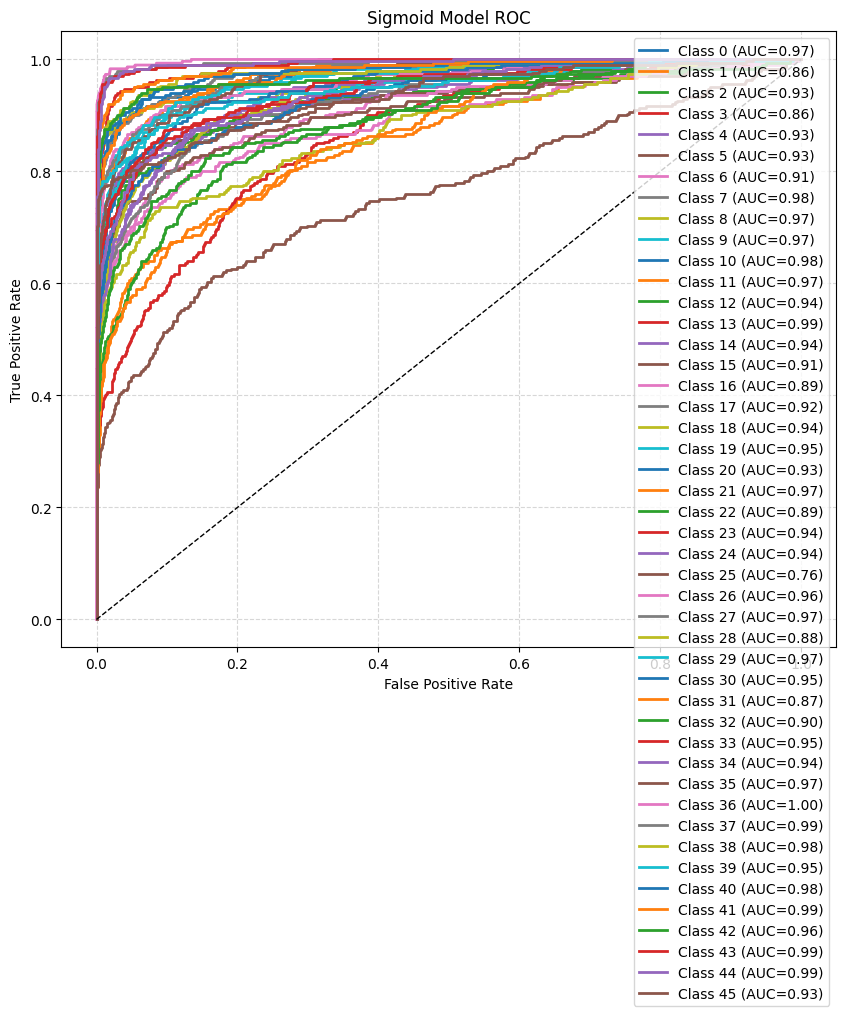

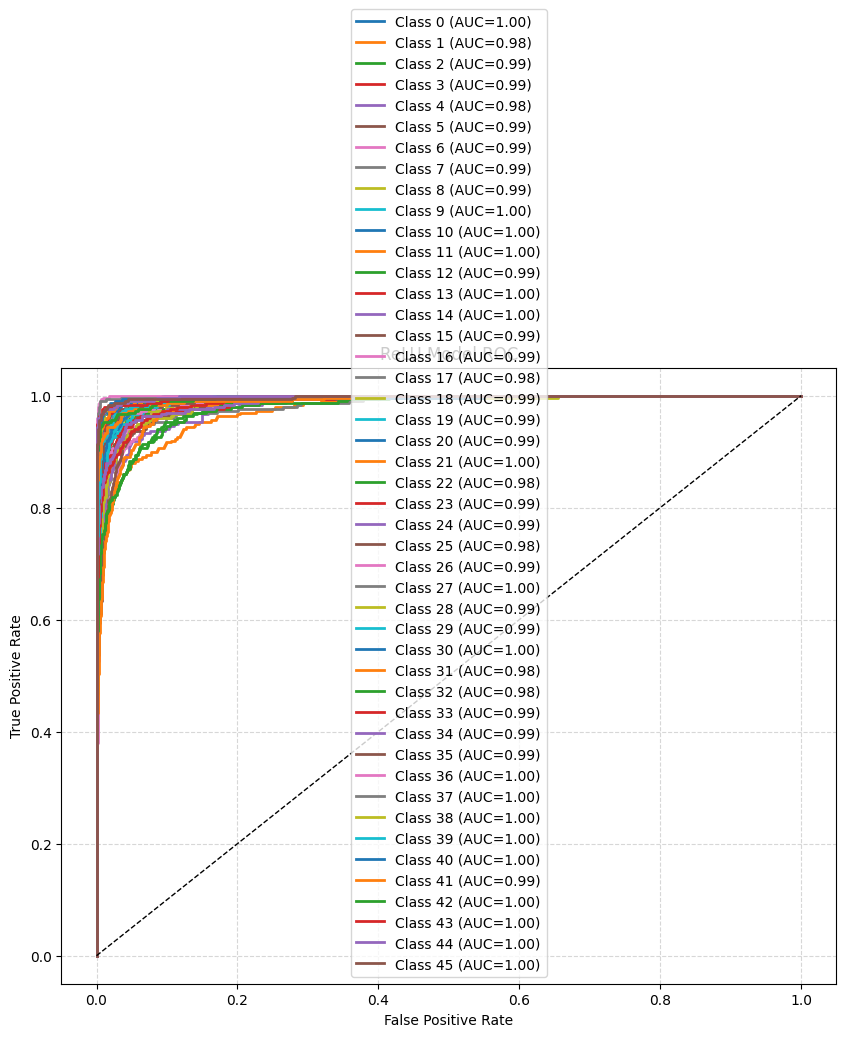

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import network
import network_relu
import os

# -------------------------------
# Load pretrained models
# -------------------------------
model_dir = os.path.join(os.getcwd(), "..", "model")
pre_model_sigmoid = os.path.join(model_dir, "digit_model_67.npz")
pre_model_relu    = os.path.join(model_dir, "digit_model_relu_60_30_0.2.npz")

net_sigmoid = network.Network([1024, 30, 46], pre_model_sigmoid)
net_relu    = network_relu.Network([1024, 60, 30, 46], pre_model_relu)

# -------------------------------
# Prepare true labels and scores
# -------------------------------
def get_scores_and_labels(net, data, num_classes=46):
    y_true = [y for x, y in data]
    y_score = np.array([net.feedforward(x) for x, _ in data])
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    return y_true_bin, y_score

y_true_sig, y_score_sig = get_scores_and_labels(net_sigmoid, test_data)
y_true_relu, y_score_relu = get_scores_and_labels(net_relu, test_data)

# -------------------------------
# Compute ROC curve for each class
# -------------------------------
def plot_multiclass_roc(y_true_bin, y_score, title="ROC Curve"):
    plt.figure(figsize=(10,8))
    num_classes = y_true_bin.shape[1]
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        # Plot some sample classes to avoid clutter
        if i < 47: 
            plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC={roc_auc:.2f})")
    
    plt.plot([0,1], [0,1], 'k--', lw=1)  # random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# -------------------------------
# Plot ROC curves
# -------------------------------
plot_multiclass_roc(y_true_sig, y_score_sig, title="Sigmoid Model ROC")
plot_multiclass_roc(y_true_relu, y_score_relu, title="ReLU Model ROC")

#### 3.2. Implementing Convolutional Neural Network

In [152]:
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf

In [153]:
# -------------------------------
# Copy original splits to new safe variables
# -------------------------------
X_train_cnn = X_train_new.copy()
Y_train_cnn = Y_train_new.copy()

X_val_cnn = X_val.copy()
Y_val_cnn = Y_val.copy()

X_test_cnn = X_test.copy()
Y_test_cnn = Y_test.copy()

In [160]:
# -------------------------------
# Normalize images 0-255 -> 0-1
# -------------------------------
X_train_cnn = X_train_cnn.astype(np.float32) / 255.0
X_val_cnn = X_val_cnn.astype(np.float32) / 255.0
X_test_cnn = X_test_cnn.astype(np.float32) / 255.0

# -------------------------------
# Add channel dimension (grayscale)
# -------------------------------
X_train_cnn = X_train_cnn.reshape(-1, 32, 32, 1)
X_val_cnn = X_val_cnn.reshape(-1, 32, 32, 1)
X_test_cnn = X_test_cnn.reshape(-1, 32, 32, 1)

# -------------------------------
# Shift labels 1-46 -> 0-45
# -------------------------------
Y_train_cnn -= 1
Y_val_cnn -= 1
Y_test_cnn -= 1

In [161]:
# -------------------------------
# Build CNN
# -------------------------------
model = models.Sequential([
    layers.Input(shape=(32,32,1)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # logits
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [162]:
# -------------------------------
# Train CNN
# -------------------------------
history = model.fit(
    X_train_cnn, Y_train_cnn,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_cnn, Y_val_cnn)
)

Epoch 1/5
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8518 - loss: 0.5238 - val_accuracy: 0.9504 - val_loss: 0.1536
Epoch 2/5
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9643 - loss: 0.1166 - val_accuracy: 0.9663 - val_loss: 0.1121
Epoch 3/5
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9779 - loss: 0.0693 - val_accuracy: 0.9728 - val_loss: 0.0957
Epoch 4/5
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9842 - loss: 0.0468 - val_accuracy: 0.9759 - val_loss: 0.0882
Epoch 5/5
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9874 - loss: 0.0385 - val_accuracy: 0.9748 - val_loss: 0.0907


In [187]:
# -------------------------------
# Evaluate on test set
# -------------------------------
test_loss, test_acc = model.evaluate(X_val_cnn, Y_val_cnn, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")


144/144 - 0s - 2ms/step - accuracy: 0.9748 - loss: 0.0907
Test Accuracy: 97.48%


#### 3.3. Implementing SVM with PCA

In [229]:
# -------------------------------
# Copy original splits to new safe variables
# -------------------------------
X_train_svm = X_train_new.copy()
Y_train_svm = Y_train_new.copy()

X_val_svm = X_val.copy()
Y_val_svm = Y_val.copy()

X_test_svm = X_test.copy()
Y_test_svm = Y_test.copy()

In [223]:
X_train_svm[0].shape

(32, 32)

In [230]:
#Flattening image 32 X 32 --> 1, 1024
X_train_svm = X_train_svm.reshape(len(X_train_svm), -1)  # 73600 x 1024
X_val_svm   = X_val_svm.reshape(len(X_val_svm), -1)      # 4600 x 1024
X_test_svm  = X_test_svm.reshape(len(X_test_svm), -1)    # 13800 x 1024

In [231]:
X_train_svm[0].shape

(1024,)

In [232]:
#applying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=200)  # can tune
X_train_pca = pca.fit_transform(X_train_svm)
X_val_pca   = pca.transform(X_val_svm)
X_test_pca  = pca.transform(X_test_svm)

In [235]:
#train SVM
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=10, gamma='scale', verbose=False)  # hyperparams
svm_model.fit(X_train_pca, Y_train_svm)  # original integer labels


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [236]:
import numpy as np
from sklearn.metrics import accuracy_score

def batch_predict(model, X, y, batch_size=500):
    n = len(X)
    preds = []
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_X = X[start:end]
        batch_y = y[start:end]
        batch_pred = model.predict(batch_X)
        preds.append(batch_pred)
        print(f"Predicted {end}/{n} samples")
    preds = np.concatenate(preds)
    acc = accuracy_score(y, preds)
    return preds, acc

# -------------------------------
# Validation
# -------------------------------
Y_val_pred, val_acc = batch_predict(svm_model, X_val_pca, Y_val_cnn)
print("Validation Accuracy:", val_acc)

# -------------------------------
# Test
# -------------------------------
Y_test_pred, test_acc = batch_predict(svm_model, X_test_pca, Y_test_cnn)
print("Test Accuracy:", test_acc)


Predicted 500/4600 samples
Predicted 1000/4600 samples
Predicted 1500/4600 samples
Predicted 2000/4600 samples
Predicted 2500/4600 samples
Predicted 3000/4600 samples
Predicted 3500/4600 samples
Predicted 4000/4600 samples
Predicted 4500/4600 samples
Predicted 4600/4600 samples
Validation Accuracy: 0.0017391304347826088
Predicted 500/13800 samples
Predicted 1000/13800 samples
Predicted 1500/13800 samples
Predicted 2000/13800 samples
Predicted 2500/13800 samples
Predicted 3000/13800 samples
Predicted 3500/13800 samples
Predicted 4000/13800 samples
Predicted 4500/13800 samples
Predicted 5000/13800 samples
Predicted 5500/13800 samples
Predicted 6000/13800 samples
Predicted 6500/13800 samples
Predicted 7000/13800 samples
Predicted 7500/13800 samples
Predicted 8000/13800 samples
Predicted 8500/13800 samples
Predicted 9000/13800 samples
Predicted 9500/13800 samples
Predicted 10000/13800 samples


KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# -------------------------------
# Flatten images
# -------------------------------
X_train_flat = X_train_svm.copy()
X_val_flat   = X_val_svm.copy()
X_test_flat  = X_test_svm.copy()

# -------------------------------
# PCA
# -------------------------------
pca = PCA(n_components=200)  # reduce 1024 → 200
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca   = pca.transform(X_val_flat)
X_test_pca  = pca.transform(X_test_flat)

# -------------------------------
# SVM grid search with progress printing
# -------------------------------
def svm_grid_search(C_list, kernel, train_x, train_y):
    best_acc = 0
    best_C = None
    for c in C_list:
        clf = SVC(C=c, kernel=kernel)
        clf.fit(train_x, train_y)
        pred_y = clf.predict(train_x)
        acc = accuracy_score(train_y, pred_y)
        print(f"C={c:.2f} → Train Accuracy: {acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            best_C = c
    return best_C

C_list = [0.1 * i for i in range(1, 30)]
kernel = 'rbf'
opt_C = svm_grid_search(C_list, kernel, X_train_pca, Y_train_svm)

print(f"\nOptimal C found: {opt_C}")

# -------------------------------
# Train final SVM with optimal C
# -------------------------------
final_svm = SVC(C=opt_C, kernel=kernel)
final_svm.fit(X_train_pca, Y_train_svm)

# Evaluate
Y_val_pred  = final_svm.predict(X_val_pca)
Y_test_pred = final_svm.predict(X_test_pca)

print("\nValidation Accuracy:", accuracy_score(Y_val_svm, Y_val_pred))
print("Test Accuracy:", accuracy_score(Y_test_svm, Y_test_pred))


C=0.10 → Train Accuracy: 87.42%
C=0.20 → Train Accuracy: 92.27%
